In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [365]:
#In this project, we will focus on comparing electrical energy production of a solar plant and consumption of a building
#This project will give the client possibility to change the size of the power plant so it fits his needs 

In [315]:
colnames=["date","time","production"]
solar=pd.read_csv('SE_10kW.csv', names=colnames, parse_dates=[['date','time']],dayfirst=True)
solar.set_index('date_time',inplace=True)
solar.head()

,production
date_time,
2017-01-27 00:15:00,0.0
2017-01-27 00:30:00,0.0
2017-01-27 00:45:00,0.0
2017-01-27 01:00:00,0.0
2017-01-27 01:15:00,0.0


In [316]:
#fill in the missing dates and times
dt=pd.date_range(start="2017-01-01 00:00:00",end="2017-12-31 23:45:00", freq="15min")
idx=pd.DatetimeIndex(dt)
solar=solar.reindex(idx)
solar.head()

,production
2017-01-01 00:00:00,NaN
2017-01-01 00:15:00,NaN
2017-01-01 00:30:00,NaN
2017-01-01 00:45:00,NaN
2017-01-01 01:00:00,NaN


In [317]:
solar=solar.reset_index();
solar.head()

,index,production
0,2017-01-01 00:00:00,NaN
1,2017-01-01 00:15:00,NaN
2,2017-01-01 00:30:00,NaN
3,2017-01-01 00:45:00,NaN
4,2017-01-01 01:00:00,NaN


In [318]:
#lets make new columns with numerical dates to make better training model for missing data
intervals=np.arange(0,96,1, dtype=float);
intervals=np.tile(intervals,365);
solar[['months','daily_interval']]=[np.nan,intervals]
for x in range(len(solar)):
    solar.iat[x,2]=solar.iloc[x,0].month    
solar.set_index('index',inplace=True)    
solar.head()    

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,production,months,daily_interval
index,,,
2017-01-01 00:00:00,NaN,1.0,0.0
2017-01-01 00:15:00,NaN,1.0,1.0
2017-01-01 00:30:00,NaN,1.0,2.0
2017-01-01 00:45:00,NaN,1.0,3.0
2017-01-01 01:00:00,NaN,1.0,4.0


In [319]:
#now lets impute the data that we miss
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
neigh=KNeighborsRegressor(n_neighbors=2)
impute_it=IterativeImputer(missing_values=np.NaN, estimator=neigh)
X=impute_it.fit_transform(solar)
solar['production']=X[:,0]

In [320]:
#now lets inspect the quality of data. We know that this power plant can produce up to 10kW and not any higher
#so we will check for outliers, inconsistent data etc
solar.describe()
#we see that the max is 10kW so that part holds, and the min production is 0 which is also good because it can't be negative
#we see that over 50% of data is below 0kW, which is also good because solar power production is possible only
#when sufficinet amount of daylight is present

,production,months,daily_interval
count,35040.000000,35040.000000,35040.000000
mean,1.529693,6.526027,47.500000
std,2.592247,3.447901,27.711705
min,0.000000,1.000000,0.000000
25%,0.000000,4.000000,23.750000
50%,0.000000,7.000000,47.500000
75%,1.992000,10.000000,71.250000
max,10.000000,12.000000,95.000000


In [321]:
#now we will group production data by months, so we can do analysis later on 
#first we map the months so they are more understandable to work with
month_mapping={
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
    5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
    9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}
solar['months']=solar['months'].map(month_mapping)
solar.head()

,production,months,daily_interval
index,,,
2017-01-01 00:00:00,0.0,Jan,0.0
2017-01-01 00:15:00,0.0,Jan,1.0
2017-01-01 00:30:00,0.0,Jan,2.0
2017-01-01 00:45:00,0.0,Jan,3.0
2017-01-01 01:00:00,0.0,Jan,4.0


In [322]:
sol=solar.groupby('months',group_keys=False, sort=False)
sol.get_group('Jan')['production'].describe() #testing the groupby

count    2976.000000
mean        0.959646
std         1.761898
min         0.000000
25%         0.000000
50%         0.000000
75%         1.183500
max         7.396000
Name: production, dtype: float64

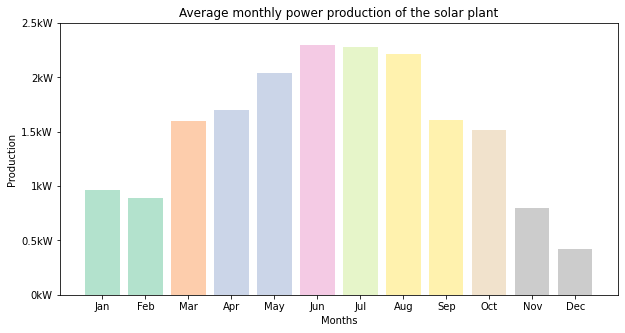

In [323]:
#now lets give a quick bar plot to overview the solar plant production potential by months
mean_production=sol['production'].mean()
mon=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(10,5))
plt.bar(mon, mean_production, color=plt.cm.Pastel2(np.linspace(0, 1, len(mean_production))))
plt.xlabel('Months')
plt.ylabel('Production')
plt.title('Average monthly power production of the solar plant');
ticks=[0,0.5,1,1.5,2,2.5]
plt.yticks(ticks,[f"{x}kW" for x in ticks]);


In [324]:
#now i will load data of power consumption of a building so later an analysis can be done
building=pd.read_csv('building.csv',parse_dates=['date'],dayfirst=True)
building.head()

,date,consumption
0,2021-09-01 00:00:00,16.392
1,2021-09-01 00:15:00,16.200
2,2021-09-01 00:30:00,16.260
3,2021-09-01 00:45:00,16.140
4,2021-09-01 01:00:00,16.008


In [325]:
#we see that the dates are not sorted but i also noticed some duplicates in dates
#we won't drop the duplicates just yet, lets inspect them first
building[building['date'].duplicated()].index
building[5196:5200]

,date,consumption
5196,2021-10-25 02:00:00,15.228
5197,2021-10-25 02:15:00,15.072
5198,2021-10-25 02:30:00,15.168
5199,2021-10-25 02:45:00,15.636


In [326]:
g=building['date']=='2021-10-25 02:00:00'
building[g]

,date,consumption
5192,2021-10-25 02:00:00,15.528
5196,2021-10-25 02:00:00,15.228


In [327]:
building[5190:5202]

,date,consumption
5190,2021-10-25 01:30:00,16.512
5191,2021-10-25 01:45:00,15.684
5192,2021-10-25 02:00:00,15.528
5193,2021-10-25 02:15:00,15.696
5194,2021-10-25 02:30:00,15.456
5195,2021-10-25 02:45:00,15.672
5196,2021-10-25 02:00:00,15.228
5197,2021-10-25 02:15:00,15.072
5198,2021-10-25 02:30:00,15.168
5199,2021-10-25 02:45:00,15.636


In [328]:
building.drop([5196,5197,5198,5199], inplace=True)
building.reindex()
building[5190:5200]

,date,consumption
5190,2021-10-25 01:30:00,16.512
5191,2021-10-25 01:45:00,15.684
5192,2021-10-25 02:00:00,15.528
5193,2021-10-25 02:15:00,15.696
5194,2021-10-25 02:30:00,15.456
5195,2021-10-25 02:45:00,15.672
5200,2021-10-25 03:00:00,15.480
5201,2021-10-25 03:15:00,14.976
5202,2021-10-25 03:30:00,15.348
5203,2021-10-25 03:45:00,15.312


In [329]:
building = building.sort_values(by='date')
building=building.set_index('date')

In [330]:
#there shoud be 35040 measures, so lets fill in for the missing dates and measures and sort the dates
dt2=pd.date_range(start="2021-01-01 00:00:00",end="2021-12-31 23:45:00", freq="15min")
idx2=pd.DatetimeIndex(dt2)
building=building.reindex(idx2)
building.tail(10)

,consumption
2021-12-31 21:30:00,17.340
2021-12-31 21:45:00,17.088
2021-12-31 22:00:00,16.752
2021-12-31 22:15:00,16.632
2021-12-31 22:30:00,17.532
2021-12-31 22:45:00,17.196
2021-12-31 23:00:00,16.860
2021-12-31 23:15:00,16.452
2021-12-31 23:30:00,16.752
2021-12-31 23:45:00,16.932


In [331]:
#lets make new columns with numerical dates to make better training model for missing data
building=building.reset_index()
intervals=np.arange(0,96,1, dtype=float)
intervals=np.tile(intervals,365)
building[['months','daily_interval']]=[np.nan,intervals]
for x in range(len(building)):
    building.iat[x,2]=building.iloc[x,0].month    
building.set_index('index',inplace=True)    
building.head()    

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,consumption,months,daily_interval
index,,,
2021-01-01 00:00:00,16.884,1.0,0.0
2021-01-01 00:15:00,17.004,1.0,1.0
2021-01-01 00:30:00,17.148,1.0,2.0
2021-01-01 00:45:00,17.448,1.0,3.0
2021-01-01 01:00:00,17.532,1.0,4.0


In [332]:
#lets inspect is the data relevant,are there any outliers, inconsistencies etc
building.describe()

,consumption,months,daily_interval
count,35030.000000,35040.000000,35040.000000
mean,21.742287,6.526027,47.500000
std,8.618242,3.447901,27.711705
min,0.876000,1.000000,0.000000
25%,16.812000,4.000000,23.750000
50%,18.060000,7.000000,47.500000
75%,24.408000,10.000000,71.250000
max,77.508000,12.000000,95.000000


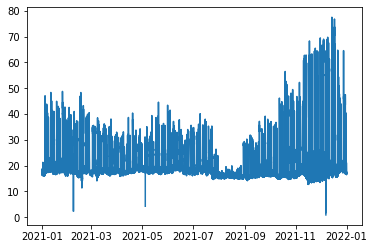

In [333]:
#we see that the average consumption is around 21kW, and the minimum value is 0.8kW, lets see is that okay
plt.plot(building['consumption'])
#this rough plot tells us that these three "negative" peaks in consumption could be due to temporary
#power loss in the building, which is not "a normal situation", so we will tahe that into consideration

In [334]:
#lets assume that the consumption shouldn't be much below 25th percentile, which is around 16kW
building['consumption'][building['consumption']<12]=np.NaN
building.isnull().sum()

consumption       16
months             0
daily_interval     0
dtype: int64

In [335]:
#now lets impute the data that we miss with previous iteration imputer
X=impute_it.fit_transform(building)
building['consumption']=X[:,0]
building.isnull().sum()

consumption       0
months            0
daily_interval    0
dtype: int64

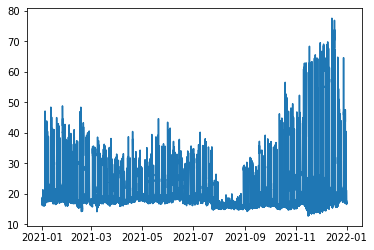

In [336]:
#now we see that there aro no peaks in minimum power consumption, those values were imputed
#high values in consumption during the winter days are due to heating 
plt.plot(building['consumption'])

In [337]:
#now lets group the data, again in respect to months
building['months']=building['months'].map(month_mapping)
G=building.groupby('months',group_keys=False, sort=False)

In [338]:
#the analysis will be based on comparing client's (building's) power consumptions (min, max, average) with production
#potential of the solar plant (min, max, average) by seasons, months, working days/weekends etc. this pallete can be 
#easily extended with many more situations
#the idea is that the client can change (input) various power production capacities (now it is 10kW, but can be less or more)
#and be provided with insights to determine is that production sufficient for his needs or what capacity of battery system
#does he need for storing any surplus of the energy

In [339]:
#now lets allow the user to input the size of solar power plant
import re
validation=re.compile("^[0-9]+\.{0,1}[0-9]{0,10}$")
test=None
while test==None:
    size=input("Please input the size of the solar power plant(numerical only) in kW, decimals separated by dot (.): ")
    test=validation.search(size)

Please input the size of the solar power plant(numerical only) in kW, decimals separated by dot (.): 50


In [340]:
solarN=solar.copy()
size=float(size)
solarN['production']=solarN['production']*size/10
solarN=solarN.reset_index().rename(columns={'index': 'date'})
building=building.reset_index().rename(columns={'index': 'date'})

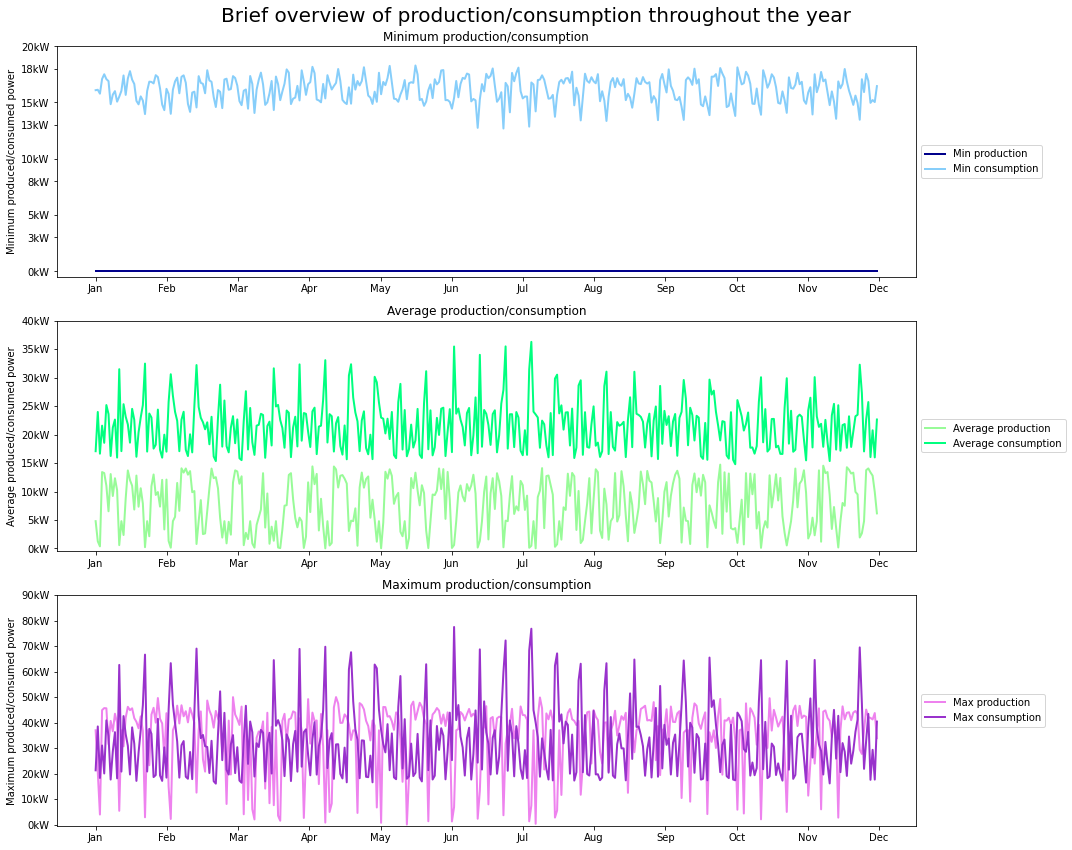

In [341]:
#lets show average, min and max production and consumption during the whole year
solarN['MMDD']=solarN['date'].dt.strftime('%d-%m')
building['MMDD']=building['date'].dt.strftime('%d-%m')
gP=solarN.groupby('MMDD')
gC=building.groupby('MMDD')
fig,axes=plt.subplots(3,1)
fig.set_size_inches(15,12)
x=np.linspace(0,365,12)

axes[0].plot(gP['production'].min(),label='Min production', color='darkblue', linewidth=2)
axes[0].plot(gC['consumption'].min(),label='Min consumption', color='lightskyblue', linewidth=2)
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[0].set_ylabel('Minimum produced/consumed power')
axes[0].set_title('Minimum production/consumption')
axes[0].set_xticks(x)
axes[0].set_xticklabels(mon)
y=axes[0].get_yticks()
Y=np.ceil(y).astype(int)
axes[0].set_yticks(Y)
axes[0].set_yticklabels([f"{k}kW" for k in Y])
axes[0].set_ylim(bottom=-0.5)

axes[1].plot(gP['production'].mean(),label='Average production', color='palegreen', linewidth=2)
axes[1].plot(gC['consumption'].mean(),label='Average consumption', color='springgreen', linewidth=2)
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[1].set_ylabel('Average produced/consumed power')
axes[1].set_title('Average production/consumption')
axes[1].set_xticks(x)
axes[1].set_xticklabels(mon)
y=axes[1].get_yticks()
Y=np.ceil(y).astype(int)
axes[1].set_yticks(Y)
axes[1].set_yticklabels([f"{k}kW" for k in Y])
axes[1].set_ylim(bottom=-0.5)

axes[2].plot(gP['production'].max(),label='Max production', color='violet', linewidth=2)
axes[2].plot(gC['consumption'].max(),label='Max consumption', color='darkorchid', linewidth=2)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[2].set_ylabel('Maximum produced/consumed power')
axes[2].set_title('Maximum production/consumption')
axes[2].set_xticks(x)
axes[2].set_xticklabels(mon)
y=axes[2].get_yticks()
Y=np.ceil(y).astype(int)
axes[2].set_yticks(Y)
axes[2].set_yticklabels([f"{k}kW" for k in Y])
axes[2].set_ylim(bottom=-0.5)

plt.suptitle('Brief overview of production/consumption throughout the year', fontsize=20)
fig.tight_layout()
plt.show()

#this overview graph will enable the client to get a quick insight if the selected power plant size
#will even roughly satisfy his consumption needs

In [342]:
#now lets make a comparison based on month inputed by user
#comparison will be made both numerically and graphically, not in terms of power (kW) but in terms of energy (kWh)
#this analysis will give the client information about electrical energy surplus that needs to be stored in batteries

full_mon=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
validation=re.compile(r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\b',
                      re.IGNORECASE)
test=None
index=-1;
while test==None:
    month=input("Please input desired month: ")
    test=validation.search(month)    

month=test.group()
for x in range(12):
    if month==mon[x] or month==mon[x].upper() or month==mon[x].lower() or month==full_mon[x] or month==full_mon[x].upper() or month==full_mon[x].lower():
        break;


Please input desired month: may


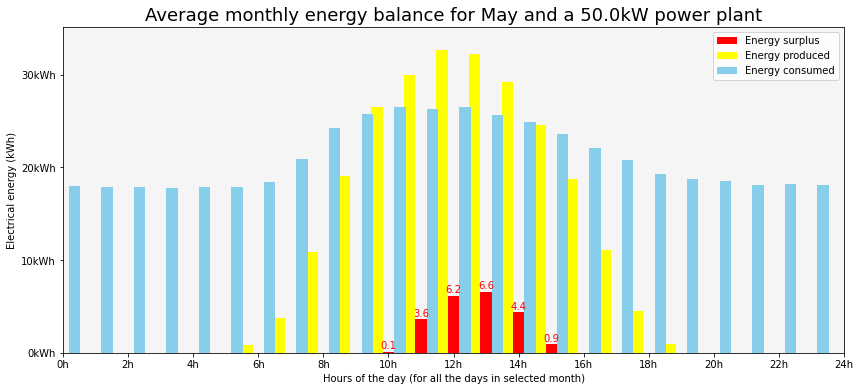

In [364]:
#we will get energy on hourly basis
sol=solarN.groupby('months')
production=sol.get_group(mon[x])['production']
production.reset_index(inplace=True, drop=True)
production=production.values.reshape((int(len(production)/96),96))
production=np.mean(production,axis=0)
production=production.reshape((24,4))
production=np.sum(production,axis=1)/4 #divided by four because energy is in kWh and we had 15min measures

consumption=G.get_group(mon[x])['consumption']
consumption.reset_index(inplace=True, drop=True)
consumption=consumption.values.reshape((int(len(consumption)/96), 96))
consumption=np.mean(consumption, axis=0)
consumption=consumption.reshape((24, 4))
consumption=np.sum(consumption, axis=1) / 4

energy=production-consumption

def label(rect):
    for r in rect:
        height=np.round(r.get_height(),1)
        plt.annotate(str(height),xy=(r.get_x()+r.get_width()/2,height),ha='center',xytext=(0,3),textcoords='offset points',color='red')

width=0.35
x_barsE=np.arange(0,24,1)
x_barsP=[value-width for value in x_barsE]
x_barsC=[value+width for value in x_barsE]
plt.figure(figsize=(14,6))
barsE=plt.bar(x_barsE,energy, width, label="Energy surplus", color="red")
barsP=plt.bar(x_barsP,production, width, label="Energy produced", color="yellow")
barsC=plt.bar(x_barsC,consumption, width, label="Energy consumed", color="skyblue")
Y=np.arange(0,int(np.max(np.maximum(production,consumption))),10)
plt.yticks(Y,[f"{k}kWh" for k in Y])
Xt=np.arange(0,25,2)
plt.xticks(Xt,[f"{k}h" for k in Xt])
label(barsE)
plt.title("Average monthly energy balance for "+ full_mon[x]+" and a " + str(size) + "kW power plant", fontsize=18)
plt.xlabel("Hours of the day (for all the days in selected month)")
plt.ylabel("Electrical energy (kWh)")
plt.xlim(0,24)
plt.ylim(bottom=0)
plt.gca().set_facecolor('whitesmoke')
plt.legend();
